# Classify images as cat or dog:
    1) Train convnet from scratch without data augmentation
    2) Train convnet from scratch with data augmentation (use of image generators)
    3) Use a pre-trained convnet for feature extraction and train a classifier on top of it with data augmentation
    4) Fine-tune a pre-trained convnet for feature extration with a pre-trained classifier on top of it (use of image generators)

###### Define the IO directories of the cat/dog dataset.

In [21]:
import os, shutil

original_dataset_dir = "catOrDog_dataset"
original_dataset_dir = os.path.join(original_dataset_dir, "train")

base_dir = "catOrDog_dataset_organized"

train_dir = os.path.join(base_dir, "train")
validation_dir = os.path.join(base_dir, "validation")
test_dir = os.path.join(base_dir, "test")

train_cats_dir = os.path.join(train_dir, "cats")
train_dogs_dir = os.path.join(train_dir, "dogs")

validation_cats_dir = os.path.join(validation_dir, "cats")
validation_dogs_dir = os.path.join(validation_dir, "dogs")

test_cats_dir = os.path.join(test_dir, "cats")
test_dogs_dir = os.path.join(test_dir, "dogs")

###### Create base_dir with the respective subfolders.

In [22]:
os.mkdir(base_dir)
os.mkdir(train_dir)
os.mkdir(validation_dir)
os.mkdir(test_dir)
os.mkdir(train_cats_dir)
os.mkdir(train_dogs_dir)
os.mkdir(validation_cats_dir)
os.mkdir(validation_dogs_dir)
os.mkdir(test_cats_dir)
os.mkdir(test_dogs_dir)

###### Copy files from original_dataset_dir to base_dir.

In [23]:

fnames = ["cat.{}.jpg".format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

fnames = ["cat.{}.jpg".format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)

fnames = ["cat.{}.jpg".format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)

fnames = ["dog.{}.jpg".format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)

fnames = ["dog.{}.jpg".format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)

fnames = ["dog.{}.jpg".format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

## 2) Train convnet from scratch with data augmentation (use of image generators)

###### Build up the convnet.
    Other than the first and last layers, you have the liberty to control how the network is going to be. 

In [24]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, 
                        (3,3), 
                        activation="relu", 
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation="relu"))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation="relu"))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation="relu"))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

###### Summarize the model. 
    Show the total number of hyperparameters to be optimized by the end of the list. Note how max pooling downgrades the input of the previous layer from (n x n) to (n/2 x n/2). 

In [25]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)       147584    
__________

###### Compile the model with:
    1) loss = binary cross entropy. Because it is a binary problem and the data is well-balanced. 
    2) optimizer = RMSprop with learning rate = 0.00004
    3) evaluation metrics = accuracy over validation data

In [16]:
from keras import optimizers

model.compile(loss="binary_crossentropy",
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=["acc"])

###### REMINDER: once the model is compiled, you need to recompile it whenever you want to change some of its parameters. 

###### Instantiate image generators. 
    In this setting, you feed the model with a stream of data points coming from the dataset. It is a common practice to play with data generators if you want to employ data augmentation.

In [26]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True, fill_mode="nearest")

test_datagen = ImageDataGenerator(rescale=1./255)

###### Data augmentation generates images from a given data by performing a random operation that does still characterizes the generated data as coming from the original data. Examples:
    1) cat img -> rotate -> generated img
    2) cat img -> translate + rotate -> generated img
    3) cat img -> crop -> generated img

###### Instantiate objects from data generators. 
    The batch_size option tells us how many images are going to be fed into the model each time. It is important to note that each random image operation is performed in parallel by the GPU (if you have enabled that option). Thus is it wise to give a number that is "easy" to parallelize with your GPU. 

###### NOTE: flow_from_directory method automatically understands that each subdirectory in base_dir (\cat or \dog) is with respect with a different class so it assigns each class with a label. In this case, class_mode="binary" so Y = {0, 1}.  

In [9]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=32,
    class_mode="binary"
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode="binary"
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


###### Train the compiled model using train_generator. Here is a short explanation of what each parameter means:
    1) steps_per_epoch = every time train_generator feeds the model, it is one step. So steps_per_epoch * batch_size is going to be the number of data points your model is going to consider one epoch. 
    2) epochs = the number of epochs based on the definition of 1 epoch = steps_per_epoch * batch_size. 
    3) validation_steps = similar to steps_per_epoch. Validation_steps * batch_size = 1 validation dataset epoch. 

In [10]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
100/100 [==============================] - 35s 349ms/step - loss: 0.6890 - acc: 0.5294 - val_loss: 0.6868 - val_acc: 0.5050
Epoch 2/100
 51/100 [==============>...............] - ETA: 11s - loss: 0.6828 - acc: 0.5643

KeyboardInterrupt: 

    Save the model as an h5 file. 

In [3]:
model.save("cats_and_dogs_small_4.h5")

NameError: name 'model' is not defined

    Output plots showing the model performance as it was trained. 

In [ ]:
import matplotlib.pyplot as plt

acc = history.history["acc"]
val_acc = history.history["val_acc"]
loss = history.history["loss"]
val_los = history.history["val_loss"]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, "bo", label="training acc")
plt.plot(epochs, val_acc, "b", label="validation acc")
plt.title("training and validation acc")
plt.legend()
plt.figure()

## 3) Use a pre-trained convnet for feature extraction and train a classifier on top of it with data augmentation

    Instantiate pretrained (weights="imagenet") convnet (VGG16) without the densely connected layer on top (include_top=False).

In [27]:
from keras.applications import VGG16

conv_base = VGG16(weights="imagenet",
                 include_top=False,
                 input_shape=(150, 150, 3))

In [19]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

    The final feature has shape (4, 4, 512). That's the featre on top of which you will stick a densely connected classifier. Or any other classifier. You might wanna test it with a SVM or logistic regression (use sckit-learn). 

In [28]:
import numpy as np

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(directory,
                                            target_size=(150,150), 
                                            batch_size=batch_size, 
                                            class_mode="binary")
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch) # this is the fit function
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count: 
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [29]:
from keras import models 
from keras import layers 
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation="relu", input_dim=4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation="sigmoid"))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
             loss="binary_crossentropy",
             metrics=["acc"])

history = model.fit(train_features, train_labels,
                   epochs=30,
                   batch_size=20,
                   validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5952 - acc: 0.6760 - val_loss: 0.4401 - val_acc: 0.8290
Epoch 2/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.4337 - acc: 0.8015 - val_loss: 0.3585 - val_acc: 0.8620
Epoch 3/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.3617 - acc: 0.8455 - val_loss: 0.3267 - val_acc: 0.8720
Epoch 4/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.3170 - acc: 0.8625 - val_loss: 0.2991 - val_acc: 0.8850
Epoch 5/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.2900 - acc: 0.8815 - val_loss: 0.2808 - val_acc: 0.8930
Epoch 6/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.2639 - acc: 0.8955 - val_loss: 0.2717 - val_acc: 0.8960
Epoch 7/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.2475 - acc: 0.9035 - val_loss: 0.2739 - val_acc: 0.8790
Epoch 8/30
200

<Figure size 432x288 with 0 Axes>

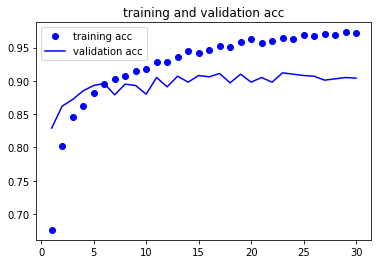

<Figure size 432x288 with 0 Axes>

In [31]:
import matplotlib.pyplot as plt

acc = history.history["acc"]
val_acc = history.history["val_acc"]
loss = history.history["loss"]
val_los = history.history["val_loss"]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, "bo", label="training acc")
plt.plot(epochs, val_acc, "b", label="validation acc")
plt.title("training and validation acc")
plt.legend()
plt.figure()

## 4) Fine-tune a pre-trained convnet for feature extration with a pre-trained classifier on top of it (use of image generators)